In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kmodes.kmodes import KModes
import seaborn as sns

# Preprocessing and Exploratory Analysis

In [50]:
cars = pd.read_csv("../car_price_prediction.csv")
cars

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


## Preprocessing

In [51]:
# Check if the dataset contains NaN/null values
cars.isnull().values.any()

False

In [52]:
cars.dtypes

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

In [53]:
# Check price for outliers by z-test and look for vals greater than 3 standard deviations
# from mean
price_outliers = cars[(np.abs(stats.zscore(cars["Price"])) >= 3)]
price_outliers

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
1225,45795524,627220,-,MERCEDES-BENZ,G 65 AMG 63AMG,2020,Jeep,Yes,Petrol,6.3 Turbo,0 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12
8541,45761204,872946,2067,LAMBORGHINI,Urus,2019,Universal,Yes,Petrol,4,2531 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0
16983,45812886,26307500,-,OPEL,Combo,1999,Goods wagon,No,Diesel,1.7,99999 km,4.0,Manual,Front,02-Mar,Left wheel,Blue,0


From the above Z-Score test we can see that we have three outliers. From market research, we have some prices for these cars:

* 2019 Lamborghini Urus: 221,000 Dollars
* 2020 Mercedes-Benz G65 AMG: 200,000 Dollars
* 1999 Opel Combo: 900 Dollars 

From this, we can see that the prices on all three of these records is significantly higher than what the cars are actually going for on the market. Thus, we are going to classify these invalid entries and remove them. 

Lets also look for invalid entries on the low end. It is unlikely that a car would sell for less than 100 dollars unless there was a specific reason for instance, it was in need of serious repair. We have of no real way of accounting for this in our data dataset and thus we will drop these values. 

In [54]:
#lows = cars[cars["Price"] <= 100]

In [55]:
cars = cars.drop(16983)
cars = cars.drop(8541)
cars = cars.drop(1225)

# for i in lows.index:
#     cars.drop(i, inplace=True)

cars.reset_index(inplace=True, drop=True)

In [56]:
# Handle Levy
ln = []
for i in cars["Levy"]:
    try:
        ln += [int(i)]
    except:
        ln += [np.NaN]

nplm = np.array(ln)    
nplm = np.nan_to_num(nplm)
cars["Levy_Numeric"] = nplm

# Handle leather interior
leather_unique = list(set(cars["Leather interior"]))   # Get all unique drive category
cars["Leather_Interior_Numeric"] = [leather_unique.index(x) for x in cars["Leather interior"]]

# Handle mileage
cars["Mileage_Numeric"] = [int(x.split(" ")[0]) for x in cars["Mileage"]]

# Handle wheel
wheel_unique = list(set(cars["Wheel"]))   # Get all unique Wheels
cars["Wheel_Numeric"] = [wheel_unique.index(x) for x in cars["Wheel"]]

# Handle engine volume by splitting a column into volume and turbo columns
volume = []
has_turbo = []
for vol in cars["Engine volume"]:
    parts = vol.split(" ")
    volume += [float(parts[0])]   # since these numbers are all small well use 16-bit float to save memory
    if len(parts) > 1:
        has_turbo += [1]
    else:
        has_turbo += [0]

cars["Engine_vol_numeric"] = volume
cars["Has_turbo"] = has_turbo
cars

# Handle model and manufacturer columns by filling with average price of model-manufacturer combinations
mm_comb = [f"{x} : {y}" for x, y in zip(cars["Manufacturer"], cars["Model"])]
avg_prices = {}
mm_comb_unique = set(mm_comb)

# Set up a dictionary to contain all average prices for models
for i in mm_comb_unique:
    avg_prices[i] = []
 

for i, price in enumerate(cars["Price"]):
    avg_prices[mm_comb[i]] += [price]

# Set values to averages
for comb in avg_prices.keys():
    avg_prices[comb] = np.array(avg_prices[comb]).mean()
    
cars["Average_price_MMC"] = [avg_prices[x] for x in mm_comb]

# Handle prod. year by transforming it to be distance from the median year
med_year = np.median(np.array(cars["Prod. year"]))
cars["Dist_from_med_PY"] = [year - med_year for year in cars["Prod. year"]]

# Handle Doors
cars["Doors_numeric"] = [np.uint16(x[1]) for x in cars["Doors"]]

cars

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,...,Airbags,Levy_Numeric,Leather_Interior_Numeric,Mileage_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY,Doors_numeric
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,...,12,1399.0,1,186005,0,3.5,0,10673.098266,-2.0,4
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,...,8,1018.0,0,192000,0,3.0,0,8751.652174,-1.0,4
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,...,2,0.0,0,200000,1,1.3,0,11088.957399,-6.0,4
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,...,0,862.0,1,168966,0,2.5,0,8159.228188,-1.0,4
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,...,4,446.0,1,91901,0,1.3,0,11088.957399,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,...,5,0.0,1,300000,0,2.0,1,7564.875000,-13.0,2
19230,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,...,8,831.0,1,161600,0,2.4,0,14438.978684,-1.0,4
19231,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,...,4,836.0,1,116365,0,2.0,0,30076.930070,-2.0,4
19232,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,...,4,1288.0,1,51258,0,2.0,0,17752.692857,-5.0,4


In [57]:
cars = cars.drop(["Manufacturer"], axis=1)
cars = cars.drop(["Model"], axis=1)
cars = cars.drop(["Levy"], axis=1)
cars = cars.drop(["Leather interior"], axis=1)
cars = cars.drop(["Mileage"], axis=1)
cars = cars.drop(["Wheel"], axis=1)
cars = cars.drop(["Engine volume"], axis=1)
cars = cars.drop(["Doors_numeric"], axis=1)
cars.rename(columns={'Prod. year': 'Prod_year', 'Fuel type': 'Fuel_type', 'Gear box type': 'Gear_box_type', 
                     'Drive wheels': 'Drive_wheels'}, inplace=True)

# Clean values in the catagorical variables for use in regression model
cleaned_catags = []
for car in cars["Category"]:
    if car == "Goods wagon":
        cleaned_catags += ["Goods_wagon"]
    else:
        cleaned_catags += [car]
cars["Category"] = cleaned_catags

cleaned_colors = []
for car in cars["Color"]:
    if " " in car:
        cleaned_colors += ["_".join(car.split(" "))]
    else:
        cleaned_colors += [car]
cars["Color"] = cleaned_colors

cleaned_fuel = []
for car in cars["Fuel_type"]:
    if " " in car:
        car = "_".join(car.split(" "))
    if "-" in car:
        car = "_".join(car.split("-"))
    cleaned_fuel += [car]
cars["Fuel_type"] = cleaned_fuel

cleaned_doors = []
for car in cars["Doors"]:
    if car == "02-Mar":
        car = "two_Mar"
    elif car == "04-May":
        car = "five_May"
    else:
        car = "more"
    cleaned_doors += [car]
cars["Doors"] = cleaned_doors

# Cast catagorical variables to uint8 for efficiency
cars["Wheel_Numeric"] = np.array(cars["Wheel_Numeric"], dtype=np.uint8)
#cars["Is_grayscale"] = np.array(cars["Is_grayscale"], dtype=np.uint8)
cars["Leather_Interior_Numeric"] = np.array(cars["Leather_Interior_Numeric"], dtype=np.uint8)
cars["Has_turbo"] = np.array(cars["Has_turbo"], dtype=np.uint8)

cars_processed = pd.get_dummies(cars).drop(["ID"], axis=1)
cars_processed

,Price,Prod_year,Cylinders,Airbags,Levy_Numeric,Leather_Interior_Numeric,Mileage_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky_blue,Color_White,Color_Yellow
0,13328,2010,6.0,12,1399.0,1,186005,0,3.5,0,...,0,0,0,0,0,0,1,0,0,0
1,16621,2011,6.0,8,1018.0,0,192000,0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
2,8467,2006,4.0,2,0.0,0,200000,1,1.3,0,...,0,0,0,0,0,0,0,0,0,0
3,3607,2011,4.0,0,862.0,1,168966,0,2.5,0,...,0,0,0,0,0,0,0,0,1,0
4,11726,2014,4.0,4,446.0,1,91901,0,1.3,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,8467,1999,4.0,5,0.0,1,300000,0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
19230,15681,2011,4.0,8,831.0,1,161600,0,2.4,0,...,0,0,0,0,0,1,0,0,0,0
19231,26108,2010,4.0,4,836.0,1,116365,0,2.0,0,...,0,1,0,0,0,0,0,0,0,0
19232,5331,2007,4.0,4,1288.0,1,51258,0,2.0,0,...,0,0,0,0,0,0,0,0,0,0


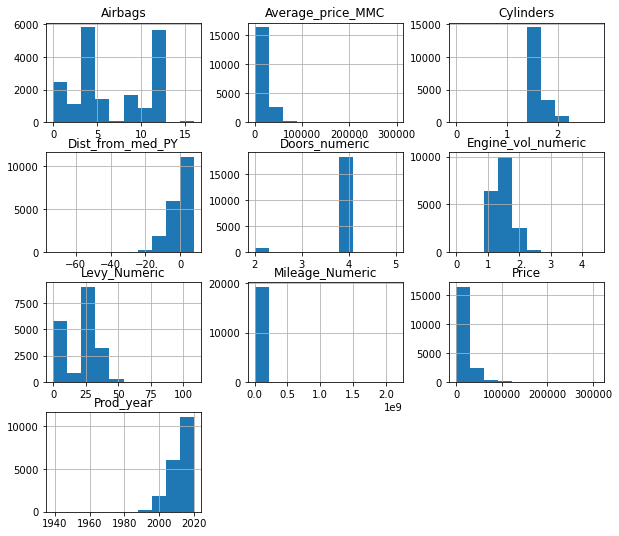

In [58]:
trans_cars_processed = cars_processed.copy()
trans_cars_processed["Levy_Numeric"] = np.sqrt(trans_cars_processed["Levy_Numeric"])
trans_cars_processed["Cylinders"] = np.log(trans_cars_processed["Cylinders"])
#trans_cars_processed["Price"] = np.sqrt(trans_cars_processed["Price"])
#trans_cars_processed["Average_price_MMC"] = np.sqrt(trans_cars_processed["Average_price_MMC"])
trans_cars_processed["Engine_vol_numeric"] = np.sqrt(trans_cars_processed["Engine_vol_numeric"])

plt.rcParams["figure.figsize"] = (10, 9)
trans_cars_processed.select_dtypes(include=[np.int64, np.float64]).hist()
plt.show()

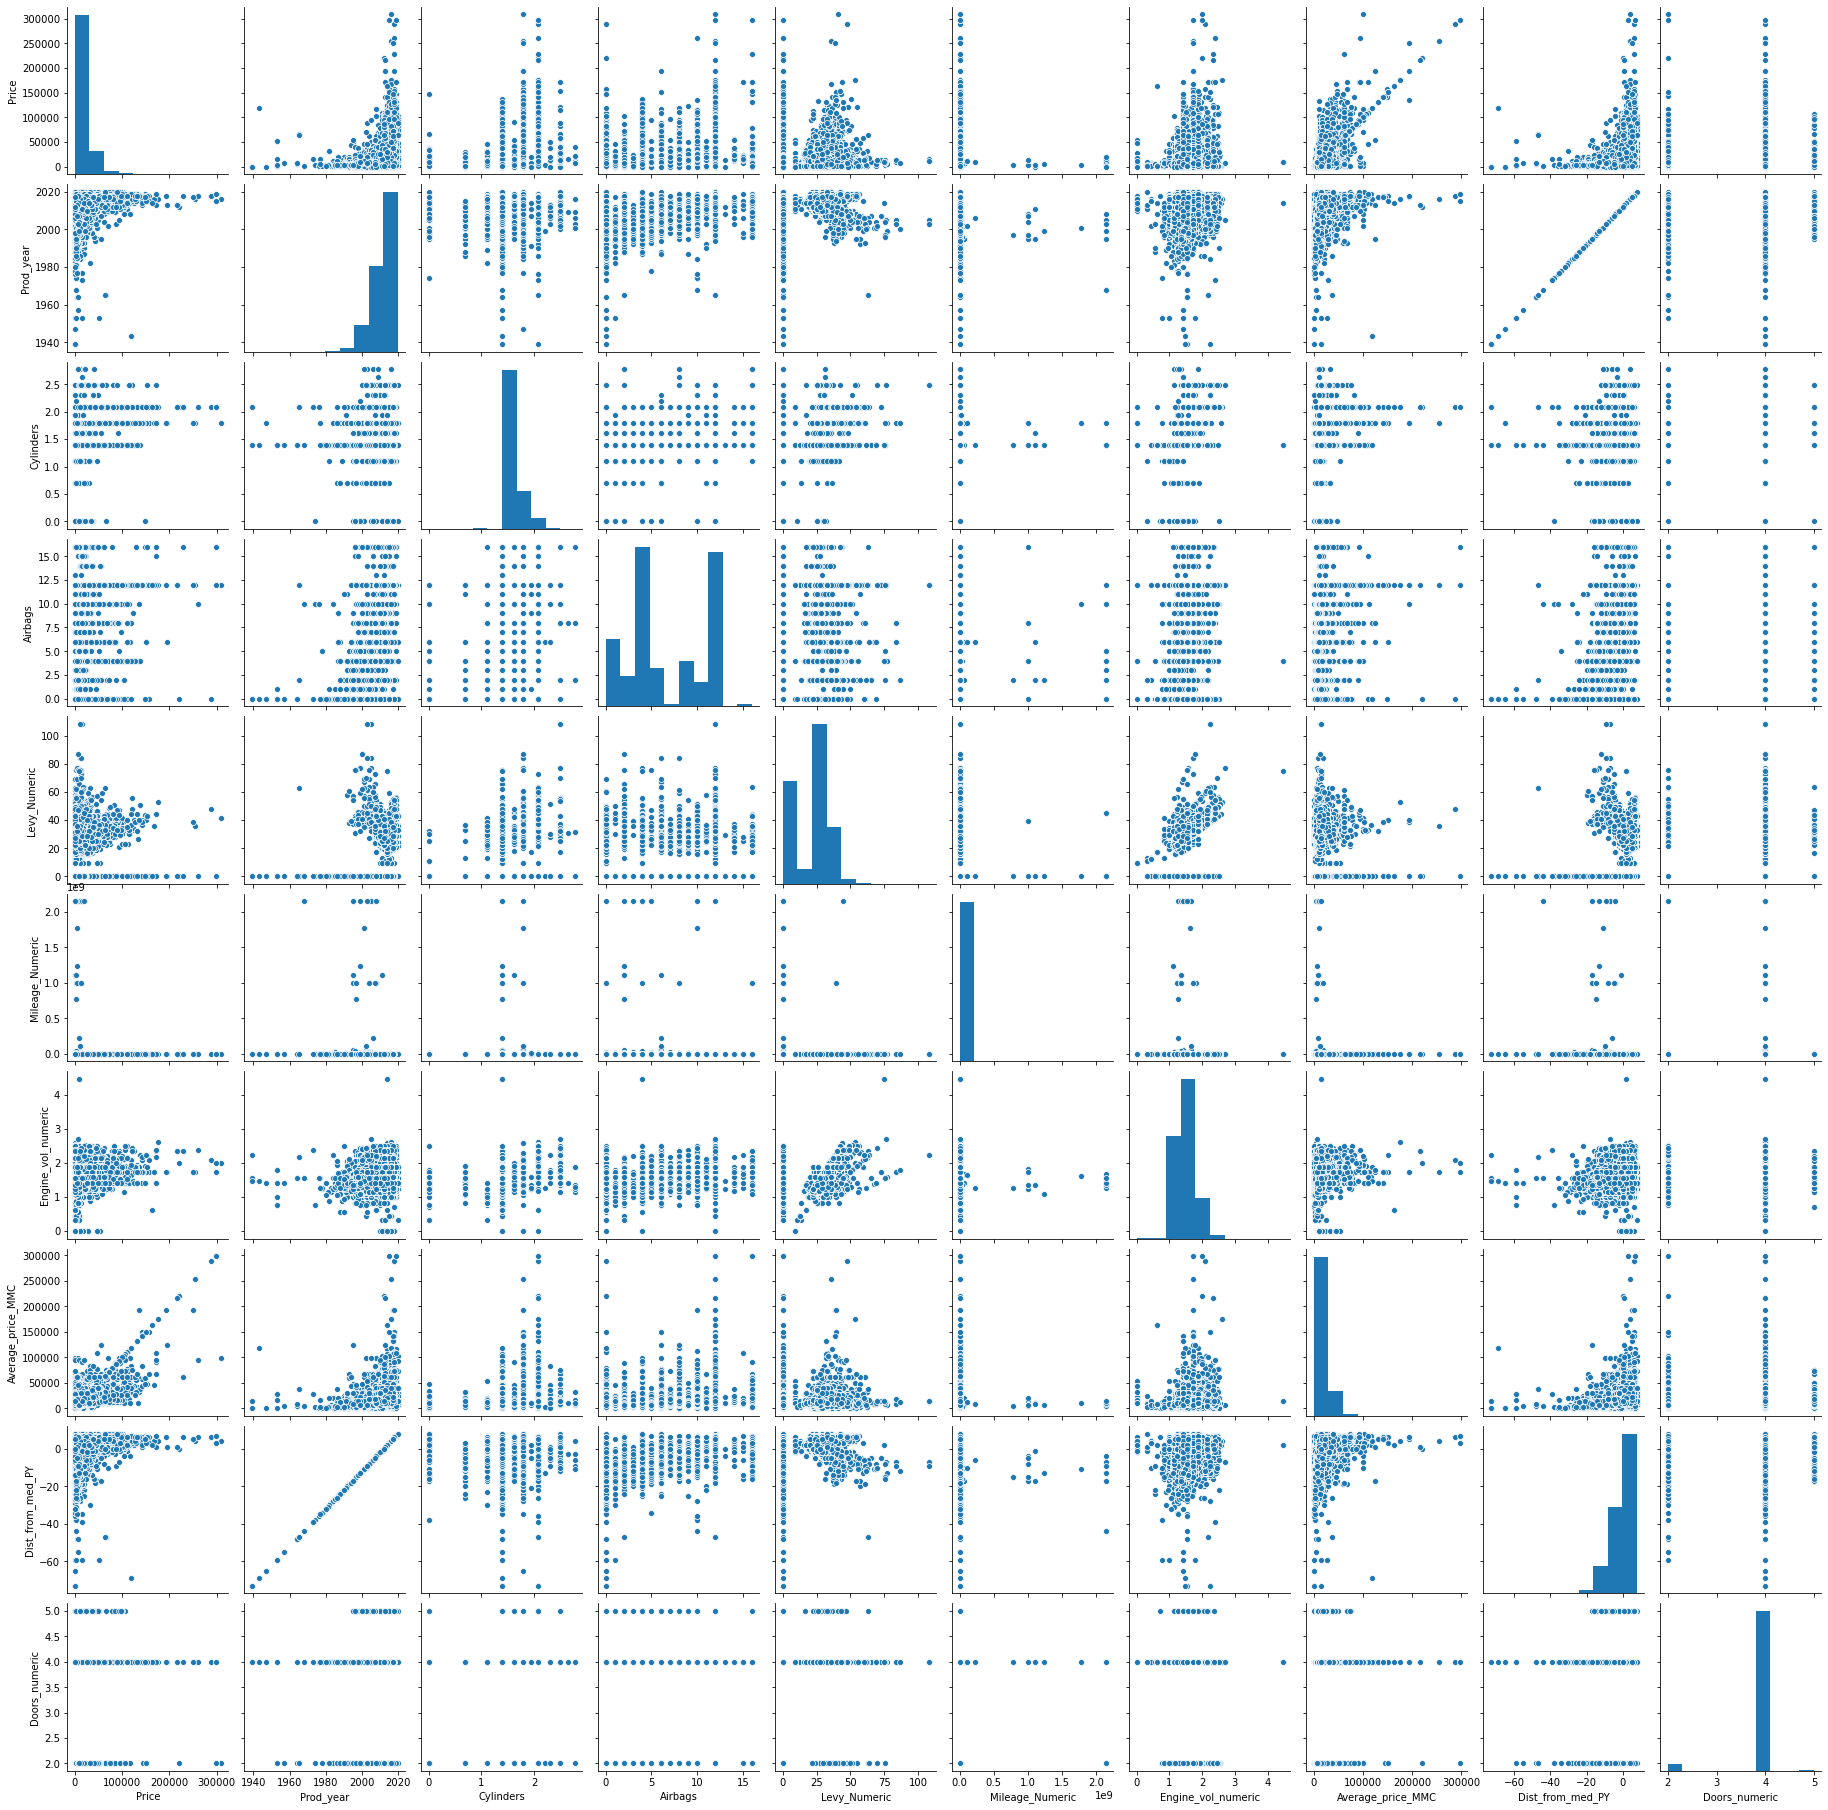

In [36]:
sns.pairplot(trans_cars_processed.select_dtypes(include=[np.int64, np.float64]))

In [59]:
grayscale = ["Grey", "Black", "Silver", "White"]
is_grayscale = []
for x in cars["Color"]:
    if x in grayscale:
        is_grayscale += [1]
    else:
        is_grayscale += [0]

cars_processed["Is_grayscale"] = is_grayscale
#cars_processed["Price"] = np.log(cars["Price"])


In [49]:
all_colors = [x for x in cars_processed.columns if "Color" in x]
colors = cars_processed[all_colors]
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(colors)

# Print the cluster centroids
print(km.cluster_centroids_)
#clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 7094.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 12191.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 7094.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 9580.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 12191.0
Best run was number 1
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [51]:
len(clusters)

19234

In [60]:
regressors = " + ".join(cars_processed.columns[1:])
equation = f"Price ~ {regressors}"
model = smf.ols(formula=equation,
                data=cars_processed).fit()
  
# model summary
all_model_summary = model.summary()
print(all_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     448.2
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:58:52   Log-Likelihood:            -2.0881e+05
No. Observations:               19234   AIC:                         4.177e+05
Df Residuals:                   19185   BIC:                         4.181e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [61]:
#help(all_model_summary)
#str(all_model_summary.tables[1][4][0])
significant_vars = []
for i in range(2, len(all_model_summary.tables[1])):
    if float(str(all_model_summary.tables[1][i][4])) < 0.05:
        significant_vars += [str(all_model_summary.tables[1][i][0])]
        
significant_vars

['Prod_year',
 'Airbags',
 'Levy_Numeric',
 'Leather_Interior_Numeric',
 'Wheel_Numeric',
 'Engine_vol_numeric',
 'Has_turbo',
 'Average_price_MMC',
 'Dist_from_med_PY',
 'Doors_numeric',
 'Category_Cabriolet',
 'Category_Goods_wagon',
 'Category_Hatchback',
 'Category_Jeep',
 'Category_Limousine',
 'Category_Microbus',
 'Category_Minivan',
 'Category_Pickup',
 'Category_Sedan',
 'Category_Universal',
 'Fuel_type_Plug_in_Hybrid',
 'Gear_box_type_Automatic',
 'Gear_box_type_Tiptronic',
 'Gear_box_type_Variator',
 'Color_Grey',
 'Color_Orange',
 'Color_Purple',
 'Color_Red',
 'Color_Silver']

In [62]:
significant_vars += ["Price"]
significant_vars_df = cars_processed[significant_vars]
significant_vars_df

,Prod_year,Airbags,Levy_Numeric,Leather_Interior_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY,Doors_numeric,...,Fuel_type_Plug_in_Hybrid,Gear_box_type_Automatic,Gear_box_type_Tiptronic,Gear_box_type_Variator,Color_Grey,Color_Orange,Color_Purple,Color_Red,Color_Silver,Price
0,2010,12,1399.0,1,0,3.5,0,10673.098266,-2.0,4,...,0,1,0,0,0,0,0,0,1,13328
1,2011,8,1018.0,0,0,3.0,0,8751.652174,-1.0,4,...,0,0,1,0,0,0,0,0,0,16621
2,2006,2,0.0,0,1,1.3,0,11088.957399,-6.0,4,...,0,0,0,1,0,0,0,0,0,8467
3,2011,0,862.0,1,0,2.5,0,8159.228188,-1.0,4,...,0,1,0,0,0,0,0,0,0,3607
4,2014,4,446.0,1,0,1.3,0,11088.957399,2.0,4,...,0,1,0,0,0,0,0,0,1,11726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,1999,5,0.0,1,0,2.0,1,7564.875000,-13.0,2,...,0,0,0,0,0,0,0,0,1,8467
19230,2011,8,831.0,1,0,2.4,0,14438.978684,-1.0,4,...,0,0,1,0,0,0,0,1,0,15681
19231,2010,4,836.0,1,0,2.0,0,30076.930070,-2.0,4,...,0,1,0,0,1,0,0,0,0,26108
19232,2007,4,1288.0,1,0,2.0,0,17752.692857,-5.0,4,...,0,1,0,0,0,0,0,0,0,5331


In [53]:
corr_matrix = significant_vars_df.corr()
corr_matrix.style.background_gradient(cmap="coolwarm")

,Prod_year,Airbags,Levy_Numeric,Leather_Interior_Numeric,Wheel_Numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY,Category_Cabriolet,Category_Coupe,Category_Goods_wagon,Category_Microbus,Category_Sedan,Category_Universal,Fuel_type_Hybrid,Fuel_type_Plug_in_Hybrid,Gear_box_type_Automatic,Gear_box_type_Manual,Gear_box_type_Tiptronic,Gear_box_type_Variator,Drive_wheels_4x4,Drive_wheels_Front,Doors_more,Doors_two_Mar,Color_Black,Color_Blue,Color_Golden,Color_Orange,Color_Red,Color_Sky_blue,Price
Prod_year,1.000000,0.233961,0.360608,0.385167,0.216030,-0.079746,0.346830,1.000000,-0.033946,-0.061835,-0.145154,-0.172115,0.083686,-0.032055,0.106245,0.025499,0.382054,-0.524861,-0.035513,-0.027511,-0.061131,0.261503,-0.039503,-0.210905,0.048486,-0.070701,-0.053008,0.070196,-0.019546,-0.048645,0.127198
Airbags,0.233961,1.000000,0.123013,0.158354,0.139377,0.060741,-0.043610,0.233961,-0.002011,0.018315,-0.084524,-0.131221,0.187079,-0.067792,0.138246,0.040825,-0.036330,-0.214521,0.221562,-0.005406,0.083948,-0.117333,0.005790,-0.050158,0.079152,-0.019047,-0.000345,-0.051198,-0.001099,-0.000933,-0.133016
Levy_Numeric,0.360608,0.123013,1.000000,0.324158,0.128020,-0.173141,0.154298,0.360608,0.008194,-0.025532,-0.056061,-0.073014,-0.016938,0.008364,-0.049214,-0.050868,0.353457,-0.254894,-0.175523,-0.110377,0.155827,-0.075341,-0.051194,-0.111351,0.066393,-0.052569,-0.034004,0.018307,-0.022903,-0.043267,-0.133469
Leather_Interior_Numeric,0.385167,0.158354,0.324158,1.000000,0.334663,-0.111346,0.252997,0.385167,0.001110,0.019436,-0.170325,-0.169891,0.095522,-0.037027,-0.035554,-0.012263,0.380336,-0.400128,-0.047885,-0.194217,0.089059,-0.044606,-0.032656,-0.120458,0.111404,-0.070153,-0.039956,0.046746,-0.045560,-0.071794,-0.081710
Wheel_Numeric,0.216030,0.139377,0.128020,0.334663,1.000000,0.027786,0.149242,0.216030,0.011963,0.012137,0.006440,0.022512,0.127530,-0.040559,-0.022360,0.015722,0.090029,0.023362,-0.018976,-0.215527,-0.000754,-0.014506,-0.003100,-0.019753,0.050765,-0.013212,-0.025853,0.021613,-0.002698,-0.040654,0.011082
Has_turbo,-0.079746,0.060741,-0.173141,-0.111346,0.027786,1.000000,0.091966,-0.079746,0.001823,0.028098,0.151425,0.225568,-0.028594,0.024471,-0.148774,-0.014936,-0.354976,0.247575,0.270416,-0.057546,0.056859,-0.186046,0.060018,0.105439,0.024658,-0.002495,0.003217,-0.023941,0.006424,0.011180,0.185109
Average_price_MMC,0.346830,-0.043610,0.154298,0.252997,0.149242,0.091966,1.000000,0.346830,-0.004891,0.016901,-0.078066,0.027267,-0.203554,0.021215,-0.139469,-0.021330,0.098343,-0.215968,0.084847,-0.062110,0.061316,-0.035660,0.004478,-0.041768,0.035256,-0.048688,-0.021892,0.005482,-0.042911,-0.031160,0.431296
Dist_from_med_PY,1.000000,0.233961,0.360608,0.385167,0.216030,-0.079746,0.346830,1.000000,-0.033946,-0.061835,-0.145154,-0.172115,0.083686,-0.032055,0.106245,0.025499,0.382054,-0.524861,-0.035513,-0.027511,-0.061131,0.261503,-0.039503,-0.210905,0.048486,-0.070701,-0.053008,0.070196,-0.019546,-0.048645,0.127198
Category_Cabriolet,-0.033946,-0.002011,0.008194,0.001110,0.011963,0.001823,-0.004891,-0.033946,1.000000,-0.007321,-0.004793,-0.005530,-0.039498,-0.006043,-0.020483,-0.002919,-0.023040,0.010534,0.024534,-0.008563,-0.022366,-0.034922,-0.003495,0.146740,0.010688,0.006848,0.010495,-0.005030,0.005779,-0.003423,0.015511
Category_Coupe,-0.061835,0.018315,-0.025532,0.019436,0.012137,0.028098,0.016901,-0.061835,-0.007321,1.000000,-0.018864,-0.021767,-0.155460,-0.023784,-0.071494,-0.011491,-0.070568,0.072180,0.045843,-0.032019,-0.062861,-0.075950,-0.009762,0.554586,0.021523,0.016640,-0.011069,-0.011415,0.061944,-0.001242,0.029865


We see strong colinearity between engine volume and cylinders, engine volume has a stronger corrolation to our dependent variable price so we will keep it and drop cylinders

engine vol 0.123430

In [54]:
significant_vars_df.drop("Dist_from_med_PY", axis=1, inplace=True)
significant_vars_df.drop("Cylinders", axis=1, inplace=True)

vif = pd.DataFrame()
vif["features"] = significant_vars_df.columns
vif["vif_Factor"] = [variance_inflation_factor(significant_vars_df.values, i) for i in range(significant_vars_df.shape[1])]
vif

C:\Users\neptu\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


KeyError: "['Cylinders'] not found in axis"

## Exploratory Analysis

In [63]:
regressors = " + ".join(significant_vars_df.columns[:26])
equation = f"Price ~ {regressors}"
model = smf.ols(formula=equation,
                data=significant_vars_df).fit()
  
# model summary
all_model_summary = model.summary()
print(all_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     849.8
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:01:45   Log-Likelihood:            -2.0888e+05
No. Observations:               19234   AIC:                         4.178e+05
Df Residuals:                   19208   BIC:                         4.180e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [128]:
regressors = " + ".join(trans_cars_processed.columns[1:])
equation = f"Price ~ {regressors}"
model = smf.ols(formula=equation,
                data=trans_cars_processed).fit()
  
# model summary
all_model_summary = model.summary()
print(all_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     353.0
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:11:19   Log-Likelihood:                -98539.
No. Observations:               18853   AIC:                         1.972e+05
Df Residuals:                   18804   BIC:                         1.976e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

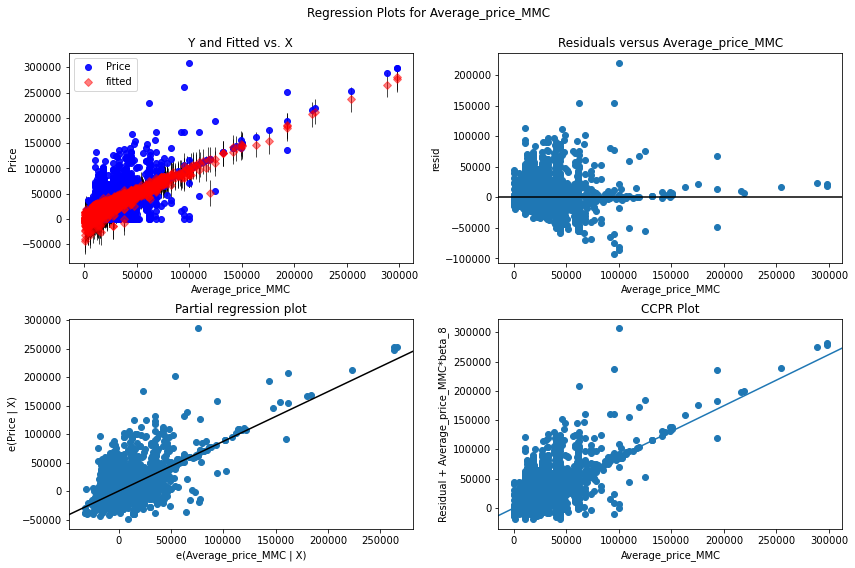

In [97]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "Average_price_MMC", fig=fig)

# plt.rcParams["figure.figsize"] = (12, 12)
# cars.hist()
# plt.show()
# # plt.hist(cars_processed["Price"], bins=40)
# # plt.show()

Text(0, 0.5, 'Price')

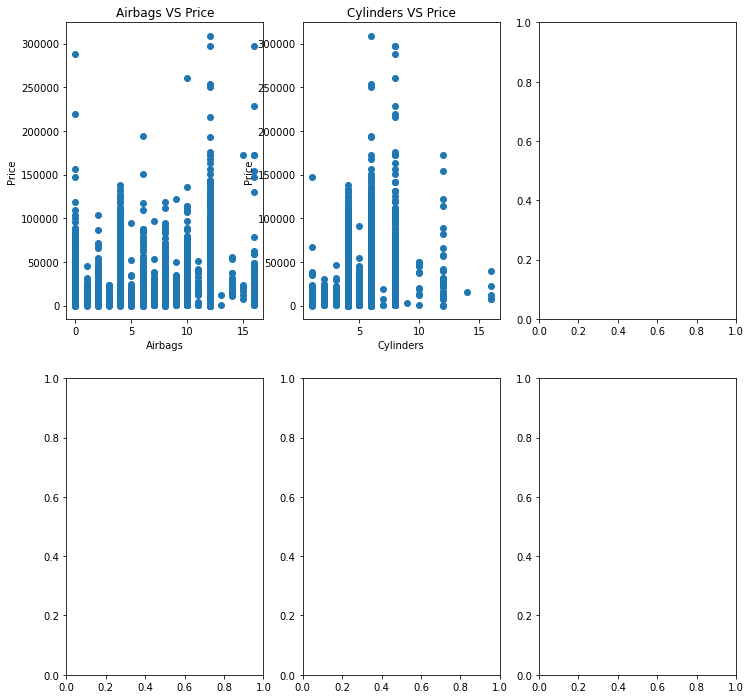

In [105]:
# plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(2, 3)

# Plot airbags vs price
axes[0, 0].scatter(cars_processed["Airbags"], cars_processed["Price"])
axes[0, 0].set_title("Airbags VS Price")
axes[0, 0].set_xlabel("Airbags")
axes[0, 0].set_ylabel("Price")

# Plot cylinders vs price
axes[0, 1].scatter(cars_processed["Cylinders"], cars_processed["Price"])
axes[0, 1].set_title("Cylinders VS Price")
axes[0, 1].set_xlabel("Cylinders")
axes[0, 1].set_ylabel("Price")

In [18]:
vif = pd.DataFrame()
vif["features"] = cars_processed.columns
vif["vif_Factor"] = [variance_inflation_factor(cars_processed.values, i) for i in range(cars_processed.shape[1])]
vif

,features,vif_Factor
0,Price,2.117419
1,Prod. year,138.689277
2,Cylinders,24.852519
3,Airbags,4.148427
4,Manufacturer_Numeric,7.123689
5,Model_Numeric,4.193019
6,Gear_box_Numeric,6.512396
7,Color_Numeric,4.601173
8,Wheel_Numeric,1.307143
9,Doors_Numeric,26.764998


In [12]:
model = smf.ols(formula='Price ~ Airbags + Manufacturer_Numeric',
                data=cars_processed).fit()
  
# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     203.7
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           2.96e-88
Time:                        19:52:36   Log-Likelihood:            -2.1584e+05
No. Observations:               19234   AIC:                         4.317e+05
Df Residuals:                   19231   BIC:                         4.317e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.258e+04 

In [32]:
pd.get_dummies(cars).columns

Index(['ID', 'Price', 'Prod. year', 'Cylinders', 'Airbags',
       'Manufacturer_Numeric', 'Model_Numeric', 'Gear_box_Numeric',
       'Color_Numeric', 'Wheel_Numeric',
       ...
       'Color_Green', 'Color_Grey', 'Color_Orange', 'Color_Pink',
       'Color_Purple', 'Color_Red', 'Color_Silver', 'Color_Sky blue',
       'Color_White', 'Color_Yellow'],
      dtype='object', length=10074)

In [98]:
cars = cars.drop(["Manufacturer"], axis=1)
cars = cars.drop(["Model"], axis=1)
cars = cars.drop(["Levy"], axis=1)
cars = cars.drop(["Leather interior"], axis=1)
cars = cars.drop(["Mileage"], axis=1)
cars = cars.drop(["Wheel"], axis=1)
cars = cars.drop(["Engine volume"], axis=1)
test = pd.get_dummies(cars)

In [48]:
set(cars["Wheel"])

{'Left wheel', 'Right-hand drive'}

In [99]:
test

,index,ID,Price,Prod. year,Cylinders,Airbags,Levy_(Numeric),Leather_Interior_Numeric,Mileage(km)_Numeric,Wheel_Numeric,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,0,45654403,13328,2010,6.0,12,1399.0,1,186005,1,...,0,0,0,0,0,0,1,0,0,0
1,1,44731507,16621,2011,6.0,8,1018.0,0,192000,1,...,0,0,0,0,0,0,0,0,0,0
2,2,45774419,8467,2006,4.0,2,0.0,0,200000,0,...,0,0,0,0,0,0,0,0,0,0
3,3,45769185,3607,2011,4.0,0,862.0,1,168966,1,...,0,0,0,0,0,0,0,0,1,0
4,4,45809263,11726,2014,4.0,4,446.0,1,91901,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18848,19232,45798355,8467,1999,4.0,5,0.0,1,300000,1,...,0,0,0,0,0,0,1,0,0,0
18849,19233,45778856,15681,2011,4.0,8,831.0,1,161600,1,...,0,0,0,0,0,1,0,0,0,0
18850,19234,45804997,26108,2010,4.0,4,836.0,1,116365,1,...,0,1,0,0,0,0,0,0,0,0
18851,19235,45793526,5331,2007,4.0,4,1288.0,1,51258,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(set(cars["Category"]))

11

In [31]:
test

,ID,Price,Prod. year,Cylinders,Airbags,Levy_(Numeric),Leather_Interior_Numeric,Mileage(km)_Numeric,Wheel_Numeric,Engine_vol_numeric,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,45654403,13328,2010,6.0,12,1399.0,1,186005,1,3.5,...,0,0,0,0,0,0,1,0,0,0
1,44731507,16621,2011,6.0,8,1018.0,0,192000,1,3.0,...,0,0,0,0,0,0,0,0,0,0
2,45774419,8467,2006,4.0,2,0.0,0,200000,0,1.3,...,0,0,0,0,0,0,0,0,0,0
3,45769185,3607,2011,4.0,0,862.0,1,168966,1,2.5,...,0,0,0,0,0,0,0,0,1,0
4,45809263,11726,2014,4.0,4,446.0,1,91901,1,1.3,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,1999,4.0,5,0.0,1,300000,1,2.0,...,0,0,0,0,0,0,1,0,0,0
19233,45778856,15681,2011,4.0,8,831.0,1,161600,1,2.4,...,0,0,0,0,0,1,0,0,0,0
19234,45804997,26108,2010,4.0,4,836.0,1,116365,1,2.0,...,0,1,0,0,0,0,0,0,0,0
19235,45793526,5331,2007,4.0,4,1288.0,1,51258,1,2.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
print(test.columns[20:30])

Index(['Category_Sedan', 'Category_Universal', 'Fuel type_CNG',
       'Fuel type_Diesel', 'Fuel type_Hybrid', 'Fuel type_Hydrogen',
       'Fuel type_LPG', 'Fuel type_Petrol', 'Fuel type_Plug-in Hybrid',
       'Gear box type_Automatic'],
      dtype='object')


(array([5.0000e+00, 4.0000e+00, 1.0000e+00, 5.0000e+00, 8.0000e+00,
        2.8000e+01, 2.4400e+02, 1.8300e+03, 5.7870e+03, 1.0941e+04]),
 array([1939. , 1947.1, 1955.2, 1963.3, 1971.4, 1979.5, 1987.6, 1995.7,
        2003.8, 2011.9, 2020. ]),
 <a list of 10 Patch objects>)

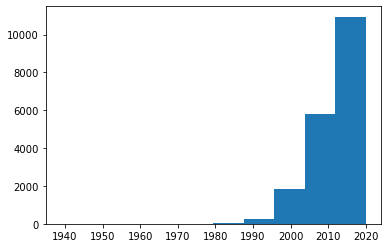

In [101]:
plt.hist(cars["Prod. year"])

In [114]:
cars[cars["Prod. year"] <= 1980]

,index,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,...,Wheel,Color,Airbags,Levy_(Numeric),Leather_Interior_Numeric,Mileage(km)_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC
448,457,45775203,15681,-,GAZ,32214,1977,Limousine,No,Petrol,...,Left wheel,Black,0,0.0,0,11111,1,2.4,0,15681.000000
3050,3111,45798484,51746,-,GAZ,20,1953,Sedan,No,Petrol,...,Left wheel,Beige,0,0.0,0,0,1,2.0,0,27473.000000
5389,5488,45776750,5331,-,UAZ,Patriot,1964,Jeep,No,Petrol,...,Left wheel,Green,0,0.0,0,50000,1,2.4,0,5645.000000
5594,5696,45801109,2437,-,VAZ,2106,1974,Sedan,No,Petrol,...,Left wheel,White,10,0.0,0,5200,1,0.6,0,3556.214286
6485,6607,32171534,119172,-,MERCEDES-BENZ,230 W153,1943,Sedan,Yes,Petrol,...,Left wheel,White,0,0.0,1,69000,1,2.2,0,119172.000000
6637,6763,45747443,1500,-,MOSKVICH,2140,1978,Goods wagon,No,Petrol,...,Left wheel,Blue,0,0.0,0,654675,1,1.5,1,1220.500000
7520,7667,45798721,65858,-,FORD,Mustang,1965,Coupe,Yes,Petrol,...,Left wheel,Red,2,0.0,1,68800,1,4.7,0,38050.794872
8421,8590,45801109,2437,-,VAZ,2106,1974,Sedan,No,Petrol,...,Left wheel,White,10,0.0,0,5200,1,0.6,0,3556.214286
8768,8942,45810269,400,-,OPEL,Crossland X,1976,Jeep,No,CNG,...,Left wheel,Red,10,0.0,0,255888,1,2.4,0,400.000000
8848,9026,45815468,314,-,MOSKVICH,401,1953,Hatchback,No,Petrol,...,Left wheel,Sky blue,1,0.0,0,150000,1,0.6,0,314.000000


In [14]:
med_year = np.median(np.array(cars["Prod. year"]))
year_dist = [year - med_year for year in cars["Prod. year"]]
# for year in cars["Prod. year"]:
#     if year < med_year:
#         year_dist += []
year_dist

[-2.0,
 -1.0,
 -6.0,
 -1.0,
 2.0,
 4.0,
 -2.0,
 1.0,
 2.0,
 -5.0,
 2.0,
 -13.0,
 -15.0,
 1.0,
 4.0,
 6.0,
 4.0,
 4.0,
 -6.0,
 -4.0,
 0.0,
 0.0,
 5.0,
 -11.0,
 -17.0,
 -6.0,
 -4.0,
 -1.0,
 -3.0,
 -5.0,
 2.0,
 -12.0,
 -4.0,
 -5.0,
 -1.0,
 7.0,
 -2.0,
 0.0,
 -2.0,
 1.0,
 4.0,
 4.0,
 2.0,
 -2.0,
 1.0,
 0.0,
 5.0,
 0.0,
 -4.0,
 4.0,
 3.0,
 -4.0,
 5.0,
 2.0,
 -11.0,
 7.0,
 3.0,
 0.0,
 6.0,
 1.0,
 -5.0,
 1.0,
 -8.0,
 1.0,
 3.0,
 2.0,
 4.0,
 1.0,
 -11.0,
 3.0,
 -1.0,
 5.0,
 4.0,
 -1.0,
 4.0,
 2.0,
 0.0,
 -4.0,
 -3.0,
 -2.0,
 7.0,
 2.0,
 -14.0,
 0.0,
 0.0,
 2.0,
 0.0,
 -2.0,
 0.0,
 2.0,
 -17.0,
 0.0,
 -4.0,
 4.0,
 1.0,
 -22.0,
 -15.0,
 -8.0,
 -3.0,
 2.0,
 1.0,
 3.0,
 -2.0,
 -8.0,
 -5.0,
 3.0,
 1.0,
 1.0,
 4.0,
 -4.0,
 5.0,
 4.0,
 -2.0,
 -7.0,
 -9.0,
 -15.0,
 1.0,
 -2.0,
 1.0,
 -17.0,
 2.0,
 -3.0,
 3.0,
 0.0,
 2.0,
 4.0,
 2.0,
 -13.0,
 -4.0,
 0.0,
 -8.0,
 -4.0,
 -1.0,
 0.0,
 -15.0,
 -2.0,
 3.0,
 1.0,
 5.0,
 2.0,
 2.0,
 1.0,
 -27.0,
 6.0,
 3.0,
 -1.0,
 2.0,
 -7.0,
 1.0,
 4.0,
 -2.0,
 2.0,
 0.0,
 

(array([5.0000e+00, 4.0000e+00, 1.0000e+00, 5.0000e+00, 8.0000e+00,
        2.8000e+01, 2.4400e+02, 1.8300e+03, 5.7870e+03, 1.0941e+04]),
 array([-73. , -64.9, -56.8, -48.7, -40.6, -32.5, -24.4, -16.3,  -8.2,
         -0.1,   8. ]),
 <a list of 10 Patch objects>)

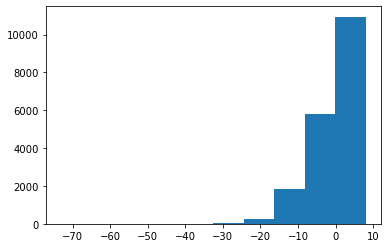

In [15]:
plt.hist(year_dist)

In [36]:
set(cars["Color"])

{'Beige',
 'Black',
 'Blue',
 'Brown',
 'Carnelian red',
 'Golden',
 'Green',
 'Grey',
 'Orange',
 'Pink',
 'Purple',
 'Red',
 'Silver',
 'Sky blue',
 'White',
 'Yellow'}

In [40]:
# Lets look at the corrolation between all car colors and see if we can create groups
colorsVprices = cars[["Price", "Color"]]
dumbo = pd.get_dummies(colorsVprices)
test = pd.get_dummies(dumbo)
corr_matrix1 = dumbo.corr()
corr_matrix1.style.background_gradient(cmap="coolwarm")

,Price,Color_Beige,Color_Black,Color_Blue,Color_Brown,Color_Carnelian red,Color_Golden,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
Price,1.000000,-0.006150,0.047364,-0.036194,0.014508,-0.006247,-0.011763,-0.054943,0.042609,-0.028359,-0.013828,-0.019736,-0.036448,-0.054644,-0.012591,0.035901,0.013186
Color_Beige,-0.006150,1.000000,-0.049700,-0.023381,-0.008250,-0.008042,-0.007259,-0.010827,-0.031329,-0.009718,-0.003097,-0.003695,-0.015430,-0.041224,-0.006613,-0.045847,-0.006266
Color_Black,0.047364,-0.049700,1.000000,-0.167358,-0.059050,-0.057566,-0.051960,-0.077497,-0.224251,-0.069562,-0.022165,-0.026449,-0.110444,-0.295075,-0.047335,-0.328165,-0.044849
Color_Blue,-0.036194,-0.023381,-0.167358,1.000000,-0.027780,-0.027082,-0.024444,-0.036458,-0.105497,-0.032725,-0.010427,-0.012443,-0.051957,-0.138816,-0.022268,-0.154383,-0.021099
Color_Brown,0.014508,-0.008250,-0.059050,-0.027780,1.000000,-0.009555,-0.008625,-0.012864,-0.037224,-0.011547,-0.003679,-0.004390,-0.018333,-0.048980,-0.007857,-0.054472,-0.007445
Color_Carnelian red,-0.006247,-0.008042,-0.057566,-0.027082,-0.009555,1.000000,-0.008408,-0.012541,-0.036288,-0.011256,-0.003587,-0.004280,-0.017872,-0.047749,-0.007660,-0.053103,-0.007257
Color_Golden,-0.011763,-0.007259,-0.051960,-0.024444,-0.008625,-0.008408,1.000000,-0.011319,-0.032754,-0.010160,-0.003237,-0.003863,-0.016131,-0.043098,-0.006914,-0.047931,-0.006551
Color_Green,-0.054943,-0.010827,-0.077497,-0.036458,-0.012864,-0.012541,-0.011319,1.000000,-0.048852,-0.015154,-0.004829,-0.005762,-0.024060,-0.064281,-0.010312,-0.071489,-0.009770
Color_Grey,0.042609,-0.031329,-0.224251,-0.105497,-0.037224,-0.036288,-0.032754,-0.048852,1.000000,-0.043850,-0.013972,-0.016673,-0.069620,-0.186006,-0.029839,-0.206865,-0.028272
Color_Orange,-0.028359,-0.009718,-0.069562,-0.032725,-0.011547,-0.011256,-0.010160,-0.015154,-0.043850,1.000000,-0.004334,-0.005172,-0.021596,-0.057699,-0.009256,-0.064169,-0.008770


In [42]:
grayscale = ["Grey", "Black", "Silver", "White"]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(dumbo.values, i) for i in range(dumbo.shape[1])]
vif['variable'] = dumbo.columns
vif

,VIF,variable
0,1.014432,Price
1,1.005420,Color_Beige
2,1.284298,Color_Black
3,1.050400,Color_Blue
4,1.011927,Color_Brown
5,1.007405,Color_Carnelian red
6,1.005125,Color_Golden
7,1.004752,Color_Green
8,1.143142,Color_Grey
9,1.006880,Color_Orange


In [43]:
grayscale = ["Grey", "Black", "Silver", "White"]
is_grayscale = []
for x in cars["Color"]:
    if x in grayscale:
        is_grayscale += [1]
    else:
        is_grayscale += [0]

is_grayscale

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,


In [45]:
c = pd.DataFrame({"Price": cars["Price"], "Color_class": is_grayscale})
# colorsVprices = cars[["Price", "Color"]]
dumbo = pd.get_dummies(c)
#test = pd.get_dummies(dumbo)
corr_matrix1 = dumbo.corr()
corr_matrix1.style.background_gradient(cmap="coolwarm")

,Price,Color_class
Price,1.000000,0.072967
Color_class,0.072967,1.000000


In [75]:
set(cars["Category"])

{'Cabriolet',
 'Coupe',
 'Goods wagon',
 'Hatchback',
 'Jeep',
 'Limousine',
 'Microbus',
 'Minivan',
 'Pickup',
 'Sedan',
 'Universal'}

In [77]:
cleaned_catags = []
for car in cars["Category"]:
    if car == "Goods wagon":
        cleaned_catags += ["Goods_wagon"]
    else:
        cleaned_catags += [car]
set(cleaned_catags)

{'Cabriolet',
 'Coupe',
 'Goods_wagon',
 'Hatchback',
 'Jeep',
 'Limousine',
 'Microbus',
 'Minivan',
 'Pickup',
 'Sedan',
 'Universal'}

In [78]:
ligma = "Ligma balls"
"_".join(ligma.split(" "))

'Ligma_balls'

In [156]:
cleaned_doors = []
for car in cars["Doors"]:
    if car == "02-Mar":
        car = "two_Mar"
    elif car == "04-May":
        car = "five_May"
    else:
        car = "more"
    cleaned_doors += [car]
set(cleaned_doors)

{'five_May', 'more', 'two_Mar'}

In [154]:
set(cars["Doors"])

{'02-Mar', '04-May', '>5'}

In [182]:
cars_processed.columns[0:]

Index(['Price', 'Prod_year', 'Cylinders', 'Airbags', 'Levy_Numeric',
       'Leather_Interior_Numeric', 'Mileage_Numeric', 'Wheel_Numeric',
       'Engine_vol_numeric', 'Has_turbo', 'Average_price_MMC',
       'Dist_from_med_PY', 'Category_Cabriolet', 'Category_Coupe',
       'Category_Goods_wagon', 'Category_Hatchback', 'Category_Jeep',
       'Category_Limousine', 'Category_Microbus', 'Category_Minivan',
       'Category_Pickup', 'Category_Sedan', 'Category_Universal',
       'Fuel_type_CNG', 'Fuel_type_Diesel', 'Fuel_type_Hybrid',
       'Fuel_type_Hydrogen', 'Fuel_type_LPG', 'Fuel_type_Petrol',
       'Fuel_type_Plug_in_Hybrid', 'Gear_box_type_Automatic',
       'Gear_box_type_Manual', 'Gear_box_type_Tiptronic',
       'Gear_box_type_Variator', 'Drive_wheels_4x4', 'Drive_wheels_Front',
       'Drive_wheels_Rear', 'Doors_five_May', 'Doors_more', 'Doors_two_Mar',
       'Color_Beige', 'Color_Black', 'Color_Blue', 'Color_Brown',
       'Color_Carnelian_red', 'Color_Golden', 'Color_Gre

In [64]:
str(all_model_summary.tables[1][7][4])

' 0.288'

# Deep Learning

In [5]:
torch.cuda.is_available()

False

(array([ 353.,  931., 1083.,  736., 1590., 4459., 6487., 2774.,  407.,
          33.]),
 array([ 4.70048037,  5.49451156,  6.28854275,  7.08257395,  7.87660514,
         8.67063633,  9.46466753, 10.25869872, 11.05272992, 11.84676111,
        12.6407923 ]),
 <a list of 10 Patch objects>)

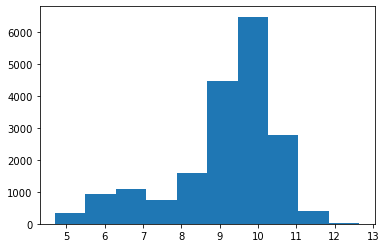

In [10]:
plt.hist(np.log(cars["Price"]))

(array([1.6021e+04, 2.3610e+03, 3.2300e+02, 9.6000e+01, 3.1000e+01,
        9.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00]),
 array([3.34210942e-07, 9.41551219e-05, 1.87976033e-04, 2.81796944e-04,
        3.75617855e-04, 4.69438766e-04, 5.63259676e-04, 6.57080587e-04,
        7.50901498e-04, 8.44722409e-04, 9.38543320e-04]),
 <a list of 10 Patch objects>)

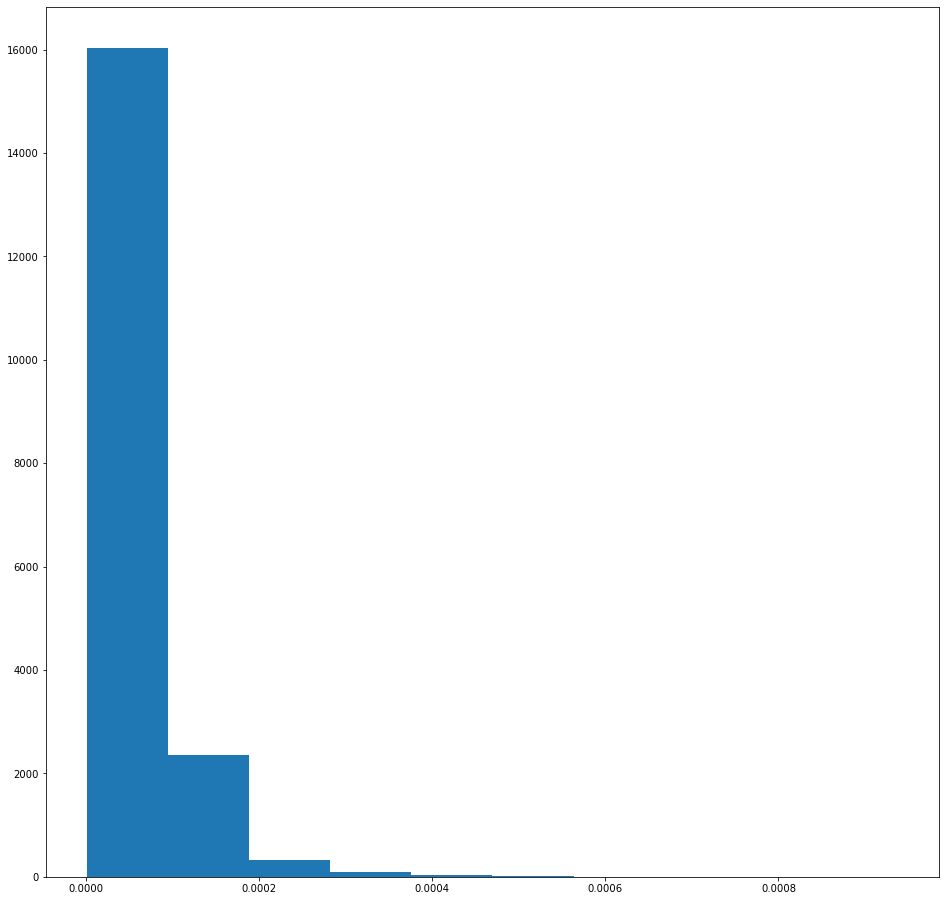

In [131]:
norm = [float(i)/sum(cars["Price"]) for i in cars["Price"]]
plt.hist(norm)

(array([1.0604e+04, 7.3040e+03, 9.0000e+02, 3.6000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 0.1 ,  2.09,  4.08,  6.07,  8.06, 10.05, 12.04, 14.03, 16.02,
        18.01, 20.  ]),
 <a list of 10 Patch objects>)

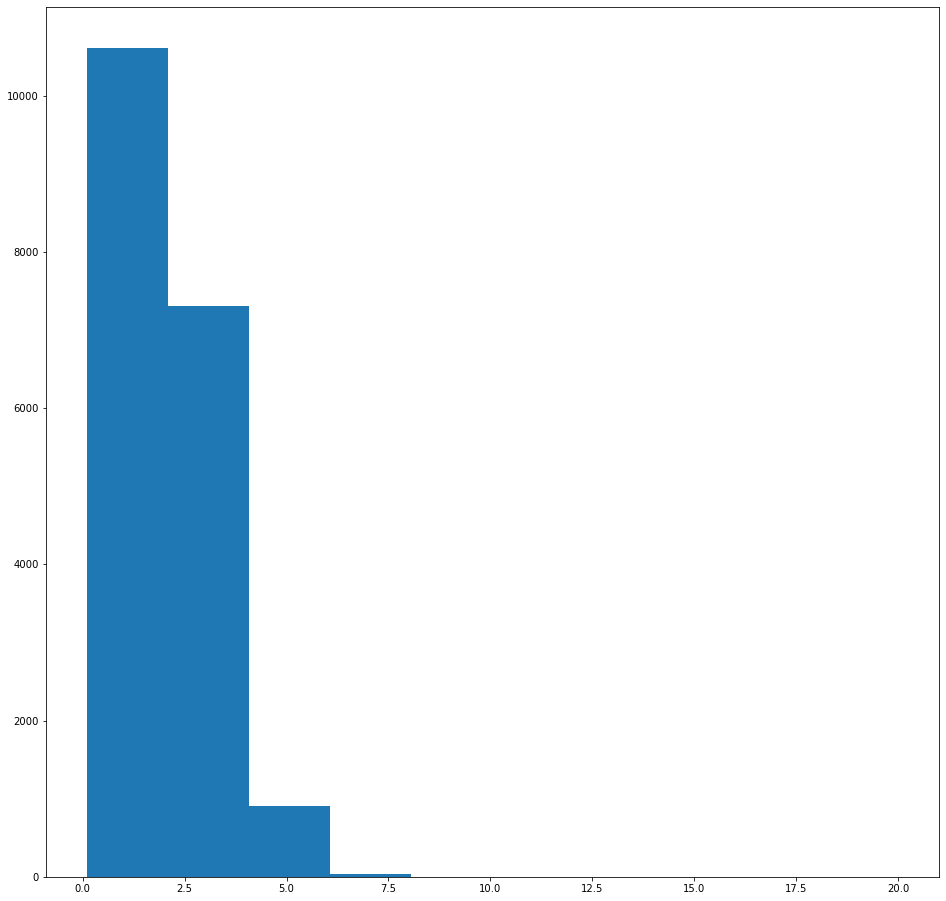

In [93]:
tdf = cars[cars["Engine_vol_numeric"] != 0]
plt.hist(tdf["Engine_vol_numeric"])

In [89]:
cars[cars["Engine_vol_numeric"] == 0]

,ID,Price,Prod_year,Category,Fuel_type,Cylinders,Gear_box_type,Drive_wheels,Doors,Color,Airbags,Levy_Numeric,Leather_Interior_Numeric,Mileage_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY
1969,45751914,53941,2018,Sedan,Petrol,6.0,Automatic,4x4,five_May,Silver,12,87.0,1,81907,1,0.0,0,53941.000000,6.0
3044,45814922,2430,2013,Coupe,Petrol,4.0,Automatic,Rear,five_May,White,12,87.0,1,121600,1,0.0,0,23413.384615,1.0
3447,45729814,27356,2016,Sedan,LPG,4.0,Automatic,Front,five_May,White,4,87.0,1,65004,1,0.0,0,16399.782080,4.0
4726,45809261,17663,2012,Hatchback,Petrol,4.0,Automatic,Front,five_May,Grey,4,87.0,1,118000,1,0.0,0,17500.334375,0.0
6891,45809887,17663,2012,Hatchback,Petrol,4.0,Automatic,Front,five_May,Grey,4,87.0,1,118000,1,0.0,0,17500.334375,0.0
7538,45729847,47076,2016,Jeep,Diesel,4.0,Automatic,Front,five_May,Black,4,87.0,1,73968,1,0.0,0,32443.845714,4.0
10404,45757531,12231,2010,Hatchback,Hybrid,4.0,Automatic,Front,five_May,Golden,0,87.0,0,0,1,0.0,0,12253.971287,-2.0


ValueError: supplied range of [-inf, 2.772588722239781] is not finite

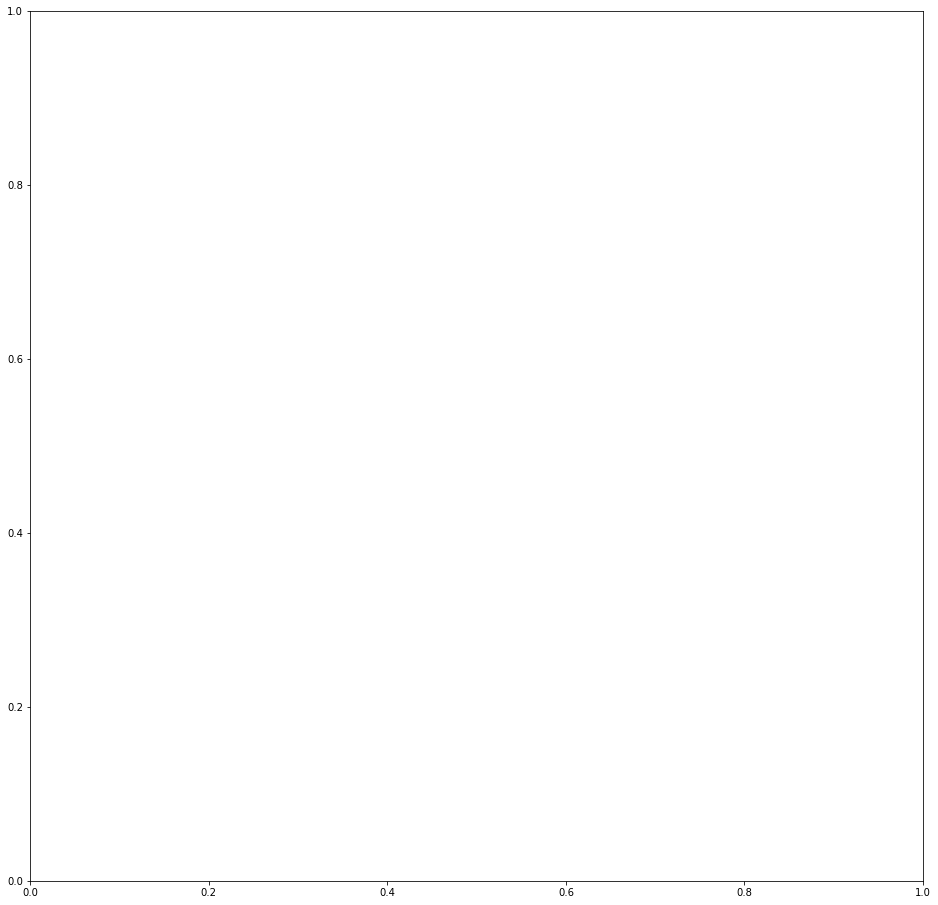

In [115]:
plt.hist(np.log(cars["Airbags"]))

In [116]:
cars[cars["Airbags"] == 0]

,ID,Price,Prod_year,Category,Fuel_type,Cylinders,Gear_box_type,Drive_wheels,Doors,Color,Airbags,Levy_Numeric,Leather_Interior_Numeric,Mileage_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY
3,45769185,3607,2011,Jeep,Hybrid,4.0,Automatic,4x4,five_May,White,0,862.0,1,168966,1,2.5,0,8269.448980,-1.0
11,45814819,8781,1999,Microbus,CNG,8.0,Manual,Rear,two_Mar,Blue,0,0.0,0,0,1,4.0,0,13919.314815,-13.0
23,45814106,7840,2001,Microbus,Diesel,4.0,Manual,Front,two_Mar,White,0,0.0,0,230000,1,2.0,1,13919.314815,-11.0
26,45759112,549,2008,Jeep,Petrol,8.0,Automatic,4x4,five_May,White,0,2455.0,1,0,1,4.7,0,21536.863946,-4.0
50,45767508,862,2015,Jeep,Petrol,6.0,Automatic,4x4,five_May,Black,0,1104.0,1,264014,1,3.0,0,12429.878788,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18795,45768736,706,2012,Jeep,Petrol,4.0,Automatic,Front,five_May,White,0,503.0,1,277856,1,1.5,0,13729.044444,0.0
18799,45647805,3607,2015,Jeep,Diesel,6.0,Automatic,4x4,five_May,Black,0,1104.0,1,201056,1,3.0,0,17874.737752,3.0
18816,45804486,28225,2015,Jeep,Petrol,4.0,Automatic,4x4,five_May,Grey,0,934.0,1,149019,1,2.5,0,23380.957831,3.0
18819,45813639,549,2010,Sedan,Hybrid,4.0,Automatic,Front,five_May,White,0,986.0,1,180234,1,2.4,0,12992.500000,-2.0


(array([1.6021e+04, 2.3610e+03, 3.2300e+02, 9.6000e+01, 3.1000e+01,
        9.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00]),
 array([-0.9480412 ,  0.73949236,  2.42702593,  4.1145595 ,  5.80209307,
         7.48962663,  9.1771602 , 10.86469377, 12.55222734, 14.2397609 ,
        15.92729447]),
 <a list of 10 Patch objects>)

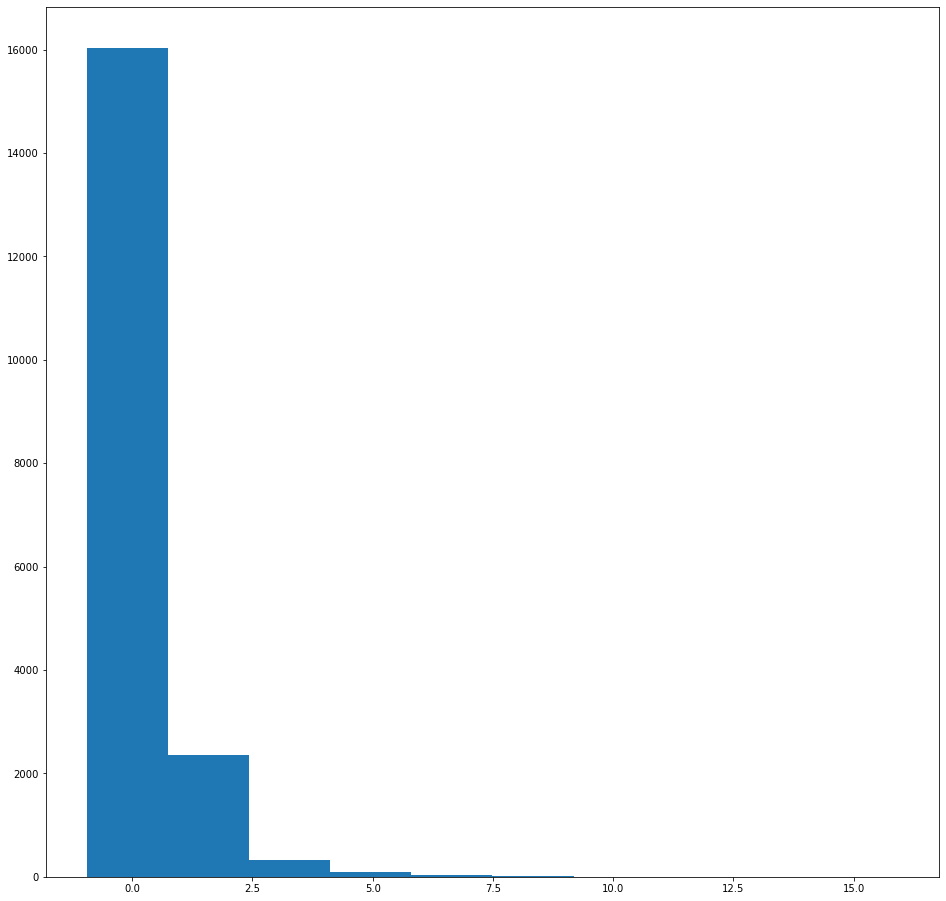

In [130]:
#plt.hist(np.sqrt(cars["Price"]))
price_mean = np.array(cars["Price"]).mean()
price_std = np.array(cars["Price"]).std()
plt.hist([(x - price_mean)/price_std for x in cars["Price"]])

In [133]:
neuralnet = tf.keras.layers.Dequential([])

[]

In [24]:
set([np.uint16(x[1]) for x in cars["Doors"]])

{2, 4, 5}